In [1]:
! pip install transformers
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 25.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DIR="/content/drive/MyDrive/Data"
LOCAL_DIR="/scratch/t.tovi/datasets"

# # # Download the datasets
# # !wget --directory-prefix=$DIR http://images.cocodataset.org/zips/train2017.zip
# # !wget --directory-prefix=$DIR http://images.cocodataset.org/zips/val2017.zip
# # !wget --directory-prefix=$DIR http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip

#Unpack the datasets
!mkdir -p {LOCAL_DIR}/COCO_stuff_images
!mkdir -p {LOCAL_DIR}/COCO_stuff_annotations

# #!cp {GOOGLE_DIR}/train2017.zip {LOCAL_DIR}/COCO_stuff_images/
!cp {GOOGLE_DIR}/val2017.zip {LOCAL_DIR}/COCO_stuff_images/
!cp {GOOGLE_DIR}/stuffthingmaps_trainval2017.zip {LOCAL_DIR}/COCO_stuff_annotations/

# #!unzip {LOCAL_DIR}/COCO_stuff_images/train2017.zip -d {LOCAL_DIR}/COCO_stuff_images/
!unzip {LOCAL_DIR}/COCO_stuff_images/val2017.zip -d {LOCAL_DIR}/COCO_stuff_images/
!unzip {LOCAL_DIR}/COCO_stuff_annotations/stuffthingmaps_trainval2017.zip -d {LOCAL_DIR}/COCO_stuff_annotations/

Streaming output truncated to the last 5000 lines.
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000222235.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000038678.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000189698.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000208363.png  
 extracting: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000572956.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000384513.png  
 extracting: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000471893.png  
 extracting: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000302536.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000531036.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000087038.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/

In [1]:
import torch
from torch import nn
from transformers import CLIPProcessor, CLIPModel, CLIPTextModelWithProjection, CLIPVisionModelWithProjection
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import tqdm


In [2]:
class CLIPLang_xatten(nn.Module):

    '''
    This class is for detecting most salient object
    in the scene as an auto-regressive task
    '''

    def __init__(self, nhead=4, nencoder=4, ndecoder=4, clip_version="openai/clip-vit-base-patch16"):
        super().__init__()

        vision_model = CLIPVisionModelWithProjection.from_pretrained(clip_version)
        text_model = CLIPTextModelWithProjection.from_pretrained(clip_version)

        # vision model
        self.vision_encoder = vision_model.vision_model
        self.vision_projector = vision_model.visual_projection

        # text model
        self.text_model = text_model.text_model
        self.text_projector = text_model.text_projection

        # internal dimensions
        self.d_text = self.text_model.embeddings.token_embedding.weight.shape[1]
        self.d_image = self.vision_encoder.embeddings.position_embedding.weight.shape[1]

        # Learnable embeddings
        self.query_embeddings = nn.Embedding(20, self.d_text)
        self.query_embeddings.weight.data.normal_(mean=0, std=0.02)

        # transformer for next label prediction
        self.decoder = nn.Transformer(
            d_model = self.d_text,
            nhead = nhead,
            num_encoder_layers = nencoder,
            num_decoder_layers = ndecoder,
            activation = nn.GELU(),
            batch_first = True
        )


    def to_embedding(self, input_ids):
        # index -> text_embeddings
        return self.text_model.embeddings.token_embedding(input_ids)

    def position_encode(self, embeddings):
        index_tensor = torch.arange(embeddings.shape[1]).repeat(embeddings.shape[0], 1).to(embeddings.device)
        return embeddings + self.text_model.embeddings.position_embedding(index_tensor)

    def visual_forward(self, pixel_values, output_hidden_states=False):
        # image -> text_embeddings
        return self.vision_encoder(pixel_values, output_hidden_states=output_hidden_states)

    def text_forward(self, text_embeddings):
        # text_embedding -> text_embeddings
        return self.text_model.encoder(text_embeddings)

    def decoder_forward(self, img_src, txt_tgt):
        # Send image seq and text seq to lang model
        return self.decoder(
            img_src,
            txt_tgt,
        )

    def cond_forward(self, pixel_values, output_hidden_states = False):
        # Get visual features
        visual_outputs = self.visual_forward(pixel_values, output_hidden_states=output_hidden_states)
        visual_features = self.vision_projector(visual_outputs.last_hidden_state)

        # Remove the [cls] token
        visual_features = visual_features[:, 1:, :]

        # Initialize query tokens
        index_tensor = torch.arange(20).repeat(pixel_values.shape[0], 1).to(pixel_values.device)
        query_tokens = self.query_embeddings(index_tensor)
        query_tokens = self.position_encode(query_tokens)

        # Decode texts
        text_pred = self.decoder_forward(visual_features, query_tokens)

        # Return both text embeddings and visual activations
        if output_hidden_states:
            return text_pred, [visual_outputs.hidden_states[i] for i in (3, 6, 9)]

        # Get text embeddings
        return text_pred

    def forward(self, pixel_values, output_hidden_states = False):

        if output_hidden_states:
            text_pred, hidden_states = self.cond_forward(pixel_values, output_hidden_states=output_hidden_states)
            return text_pred, hidden_states

        return self.cond_forward(pixel_values)

class AutoSeg(nn.Module):
    def __init__(self, d_reduce=64, nhead=4, nencoder=4, ndecoder=4):
        super().__init__()

        self.encoders = CLIPLang_xatten(nhead=nhead, nencoder=nencoder, ndecoder=ndecoder)
        self.reduces = nn.ModuleList([
            nn.Linear(self.encoders.d_image, d_reduce) for _ in range(3)
        ])
        self.film_mul = nn.Linear(self.encoders.d_text, d_reduce)
        self.film_add = nn.Linear(self.encoders.d_text, d_reduce)

        self.decoder = nn.ModuleList([
            nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=d_reduce,
                    nhead=nhead,
                    dim_feedforward=2048,
                    dropout=0.1,
                    activation=nn.GELU(),
                    batch_first=True,
                ),
                num_layers=1,
            )
            for _ in range(3)
        ])

        self.mask_head = nn.Sequential(
            nn.Conv2d(d_reduce, d_reduce, kernel_size=(3, 3), padding=(1, 1), padding_mode="replicate"),
            nn.GELU(),
            nn.ConvTranspose2d(d_reduce, d_reduce//2, kernel_size=(4, 4), stride=(4, 4)),
            nn.GELU(),
            nn.ConvTranspose2d(d_reduce//2, 1, kernel_size=(4, 4), stride=(4, 4))
        )

    def forward(self, pixel_values):
        # Get text embeddings
        lang_output, hidden_states = self.encoders.cond_forward(pixel_values, output_hidden_states=True)

        # Image sequence size
        self.image_seq_size = int(np.sqrt(hidden_states[0].shape[1]))

        masks = []
        for i, batch_embeddings in enumerate(lang_output.permute(1, 0, 2)):
            a  = None
            for hs, block, reduce in zip(hidden_states, self.decoder, self.reduces):
                hs = hs.permute(1, 0, 2)
                if a is None:
                    a = reduce(hs)
                else:
                    a = a + reduce(hs)

                a = a * self.film_mul(batch_embeddings) + self.film_add(batch_embeddings)
                a = block(a)

            a = a[1:].permute(1, 2, 0)
            a = a.view(a.shape[0], a.shape[1], self.image_seq_size, self.image_seq_size)
            a = self.mask_head(a)
            masks.append(a)

        masks = torch.cat(masks, dim=1)
        return masks, lang_output

In [3]:
src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "COCO_stuff_images/val2017/"
annotation_dir = "COCO_stuff_annotations/val2017/"

class COCOStuffDatasetEval(Dataset):
    def __init__(self, image_dir, annotation_dir, img_size=224):
        """
        Args:
            image_dir (string): Directory with all the images.
            annotation_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.images = os.listdir(image_dir)
        self.img_size = img_size

        self.selected_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48,
                                49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]

        # Load the label mapping
        self.digit_to_object_mapping = {}
        with open(f'{src_dir}labels.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(':')
                self.digit_to_object_mapping[int(key)] = value.strip()
        self.digit_to_object_mapping[255] = "unlabled"

    def center_crop(self, image, mask):
        transform = transforms.CenterCrop(self.img_size)
        return transform(image), transform(mask)

    def resize(self, image, mask):
        transform = transforms.CenterCrop(min(image.size))

        cropped_image = transform(image)
        cropped_mask = transform(mask)

        resized_image = transforms.Resize((self.img_size, self.img_size),transforms.InterpolationMode.BILINEAR)(cropped_image)
        resized_mask= transforms.Resize((self.img_size, self.img_size), transforms.InterpolationMode.NEAREST)(cropped_mask)
        return resized_image, resized_mask

    def __len__(self):
        return len(self.images)

    def get(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)#.convert('RGB')

        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        ids = np.unique(np.array(annotation))
        ids = [id for id in ids if id in self.selected_labels]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        return image, annotation, labels

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        image, mask = self.resize(image, annotation)
        mask = np.array(mask)
        mask += 1
        mask[mask==256] = 0


        # Indexed masks
        ids = np.unique(mask)
        ids = [id for id in ids if id in self.selected_labels]
        nonempty_masks = [np.full(mask.shape, id) * (mask==id) for id in ids]
        nonempty_masks = sorted(nonempty_masks, key=lambda x: np.sum(x!=0), reverse=True)

        # Get ids and labels
        ids = [np.unique(mask)[-1] for mask in nonempty_masks]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        # Convert to binary masks
        nonempty_masks = [(mask != 0).astype(float) for mask in nonempty_masks]

        sample = {'image': image, 'annotation': nonempty_masks, 'labels': labels, 'ids': ids}

        return sample

In [4]:
def collate_fn_factory(processor, max_size=20):

    def collate_fn(batch):
        size = processor.image_processor.size['shortest_edge'] #224
        transform = transforms.ToTensor()

        # Preprocess pixel values
        images = [each['image'] for each in batch]
        batch_pixel_values = processor(None, images=images, return_tensors='pt')['pixel_values']

        # Preprocess labels
        ids = torch.full((len(batch), max_size), 0)
        ids[:, :max_size] = torch.tensor([each['ids'][:max_size] + [0] * (max_size - len(each['ids'])) for each in batch])

        # Preprocess masks
        batch_masks = np.stack([
            np.stack(each['annotation'][:max_size] + [np.zeros((size, size))] * (max_size - len(each['annotation'])) )
            for each in batch
        ])
        batch_masks = torch.tensor(batch_masks[:, :max_size])

        return {
            "pixel_values": batch_pixel_values,
            "masks": batch_masks.type(torch.float32),
            "ids": ids.type(torch.long)
        }

    return collate_fn

In [102]:
import math

def mean_iou(y_true, y_pred, classes):
    """
    Compute the Intersection over Union (IoU) for each class in the list.

    Parameters:
    y_true (np.array): The ground truth labels.
    y_pred (np.array): The predicted labels.
    classes (list): A list of class IDs to compute IoU for.

    Returns:
    np.array: An array of IoUs for each class in the list.
    """
    iou_list = []
    for class_id in classes:
        true_positive = torch.sum((y_true == class_id) & (y_pred == class_id))
        false_positive = torch.sum((y_true != class_id) & (y_pred == class_id))
        false_negative = torch.sum((y_true == class_id) & (y_pred != class_id))
        union = true_positive + false_positive + false_negative

        if union == 0:
            iou = 1.0  # Perfect match or no data for the class
        else:
            iou = true_positive / union

        if torch.isnan(iou):
            iou = 0.0

        iou_list.append(iou.detach().cpu().item())
    return np.mean(iou_list), iou_list

In [6]:
! cp drive/MyDrive/Data/autoseg_v0.3 ./

In [7]:
model = AutoSeg(d_reduce=128)
model.load_state_dict(torch.load('autoseg_v0.3'))
model = model.to(0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
device = 0

# Define dataset dir
dataset_dir = "/scratch/t.tovi/datasets/"

# Create dataset object
data = COCOStuffDatasetEval(
    dataset_dir+"COCO_stuff_images/val2017",
    dataset_dir+"COCO_stuff_annotations/val2017",
    img_size=224
)

lang_model = CLIPLang_xatten()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# Get loss query table

labels = data.digit_to_object_mapping
label_indices = list(data.digit_to_object_mapping.keys())
label_text = ["a photo of " + data.digit_to_object_mapping[each] for each in label_indices]
label_indices = processor(label_text, padding=True, return_tensors='pt')['input_ids']

with torch.no_grad():
    label_embeddings = lang_model.text_model(label_indices)["pooler_output"]
    eos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.eos_token_id]))["pooler_output"]
    bos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.bos_token_id]))["pooler_output"]

    label_embeddings = lang_model.text_projector(label_embeddings)
    eos_embedding = lang_model.text_projector(eos_embedding)
    bos_embedding = lang_model.text_projector(bos_embedding)

label_embeddings.requires_grad_(False)
eos_embedding.requires_grad_(False)
bos_embedding.requires_grad_(False)

reverse_mapping = {v: k for k, v in data.digit_to_object_mapping.items()}

In [10]:
# Get the collate function
collate_fn = collate_fn_factory(processor)

# Create batch data loader
data_loader = DataLoader(data, batch_size=1, collate_fn=collate_fn, num_workers=0, shuffle=True)

m = nn.Sigmoid()
temperature = 0.02
label_embeddings = label_embeddings.to(0)
label_embeddings = F.normalize(label_embeddings, dim=-1)

In [11]:
all_miou = []
for batch in tqdm.tqdm(data_loader):
    pixel_values = batch['pixel_values'].to(device)
    masks = batch['masks'].to(device)
    ids = batch['ids'].to(device)

    mask_logits, pred_embeddings = model(pixel_values)

    ids = batch['ids'].squeeze(0)
    ids = ids[ids != 0]
    ground_truth_embeddings = label_embeddings[ids]
    predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
    correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

    predicted_masks = (m(mask_logits[0, correspondence])> 0.3).int()
    for i in range(len(ids)):
        predicted_masks[i] = predicted_masks[i] * ids[i]

    ground_truth_masks = masks.squeeze(0)[: len(ids)]
    for i in range(len(ids)):
        ground_truth_masks[i] = ground_truth_masks[i] * ids[i]

    score = mean_iou(ground_truth_masks, predicted_masks, ids)
    all_miou.append(score)

    if len(all_miou) % 100 == 0:
        print(np.nanmean(all_miou))


  1%|          | 35/5000 [00:05<10:53,  7.59it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 101/5000 [00:14<10:14,  7.98it/s]

0.46942796851490454


  4%|▍         | 201/5000 [00:27<09:44,  8.21it/s]

0.49805614170463497


  6%|▌         | 301/5000 [00:40<10:01,  7.81it/s]

0.4967235127164039


  8%|▊         | 387/5000 [00:52<10:31,  7.30it/s]


KeyboardInterrupt: 

## Pascal VOC Eval

In [ ]:
#Unpack the datasets
#!mkdir -p {LOCAL_DIR}/VOCdevkit

!cp {GOOGLE_DIR}/VOCtrainval_11-May-2012.tar {LOCAL_DIR}

!tar -xvf {GOOGLE_DIR}/VOCtrainval_11-May-2012.tar -C {LOCAL_DIR}

cp: cannot stat '{GOOGLE_DIR}/VOCtrainval_11-May-2012.tar': No such file or directory
tar: {GOOGLE_DIR}/VOCtrainval_11-May-2012.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "VOCdevkit/VOCdevkit/VOC2012/JPEGImages/"
annotation_dir = "VOCdevkit/VOCdevkit/VOC2012/SegmentationClass/"
val_ids = "VOCdevkit/VOCdevkit/VOC2012/ImageSets/Main/val.txt"

class PascalDatasetEval(Dataset):
    def __init__(self, val_ids_file, image_dir, annotation_dir, img_size=224):
        """
        Args:
            image_dir (string): Directory with all the images.
            annotation_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = []
        with open(val_ids_file, 'r') as file:
            for line in file:
                id = line.strip() + ".jpg"
                self.images.append(id)

        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.img_size = img_size

        # Load the label mapping
        self.digit_to_object_mapping = {}
        with open(f'{src_dir}test_labels.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(':')
                self.digit_to_object_mapping[int(key)] = value.strip()
        self.digit_to_object_mapping[255] = "unlabled"

    def center_crop(self, image, mask):
        transform = transforms.CenterCrop(self.img_size)
        return transform(image), transform(mask)

    def resize(self, image, mask):
        transform = transforms.CenterCrop(min(image.size))

        cropped_image = transform(image)
        cropped_mask = transform(mask)

        resized_image = transforms.Resize((self.img_size, self.img_size),transforms.InterpolationMode.BILINEAR)(cropped_image)
        resized_mask= transforms.Resize((self.img_size, self.img_size), transforms.InterpolationMode.NEAREST)(cropped_mask)
        return resized_image, resized_mask

    def __len__(self):
        return len(self.images)

    def get(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)#.convert('RGB')

        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        ids = np.unique(np.array(annotation))
        labels = [self.digit_to_object_mapping[id] for id in ids]

        return image, annotation, labels

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)#.convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        image, mask = self.resize(image, annotation)
        mask = np.array(mask)
        #mask += 1
        mask[mask==255] = 0


        # Indexed masks
        ids = np.unique(mask)
        ids = [id for id in ids if id != 0]
        nonempty_masks = [np.full(mask.shape, id) * (mask==id) for id in ids]
        nonempty_masks = sorted(nonempty_masks, key=lambda x: np.sum(x!=0), reverse=True)

        # Get ids and labels
        ids = [np.unique(mask)[-1] for mask in nonempty_masks]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        # Convert to binary masks
        nonempty_masks = [(mask != 0).astype(float) for mask in nonempty_masks]

        sample = {'image': image, 'annotation': nonempty_masks, 'labels': labels, 'ids': ids}

        return sample

In [ ]:
device = 0

src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "VOCdevkit/VOC2012/JPEGImages/"
annotation_dir = "VOCdevkit/VOC2012/SegmentationClass/"
val_ids = "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"

# Define dataset dir
dataset_dir = "/scratch/t.tovi/datasets/"

# Create dataset object
data = PascalDatasetEval(
    dataset_dir+val_ids,
    dataset_dir+image_dir,
    dataset_dir+annotation_dir,
    img_size=224
)

lang_model = CLIPLang_xatten()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [ ]:
# Get loss query table

labels = data.digit_to_object_mapping
label_indices = list(data.digit_to_object_mapping.keys())
label_text = ["a photo of " + data.digit_to_object_mapping[each] for each in label_indices]
label_indices = processor(label_text, padding=True, return_tensors='pt')['input_ids']

with torch.no_grad():
    label_embeddings = lang_model.text_model(label_indices)["pooler_output"]
    eos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.eos_token_id]))["pooler_output"]
    bos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.bos_token_id]))["pooler_output"]

    label_embeddings = lang_model.text_projector(label_embeddings)
    eos_embedding = lang_model.text_projector(eos_embedding)
    bos_embedding = lang_model.text_projector(bos_embedding)

label_embeddings.requires_grad_(False)
eos_embedding.requires_grad_(False)
bos_embedding.requires_grad_(False)

reverse_mapping = {v: k for k, v in data.digit_to_object_mapping.items()}

In [ ]:
# Get the collate function
collate_fn = collate_fn_factory(processor)

# Create batch data loader
data_loader = DataLoader(data, batch_size=1, collate_fn=collate_fn, num_workers=2, shuffle=True)

m = nn.Sigmoid()
temperature = 0.02
label_embeddings = label_embeddings.to(0)
label_embeddings = F.normalize(label_embeddings, dim=-1)

In [ ]:
all_miou = []
for batch in tqdm.tqdm(data_loader):
    pixel_values = batch['pixel_values'].to(device)
    masks = batch['masks'].to(device)
    ids = batch['ids'].to(device)

    mask_logits, pred_embeddings = model(pixel_values)

    ids = batch['ids'].squeeze(0)
    ids = ids[ids != 0]
    ground_truth_embeddings = label_embeddings[ids]
    predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
    correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

    predicted_masks = (m(mask_logits[0, correspondence]) > 0.3).int()
    for i in range(len(ids)):
        predicted_masks[i] = predicted_masks[i] * ids[i]

    ground_truth_masks = masks.squeeze(0)[: len(ids)]
    for i in range(len(ids)):
        ground_truth_masks[i] = ground_truth_masks[i] * ids[i]
    break
    score = mean_iou(ground_truth_masks, predicted_masks, ids)
    all_miou.append(score)

    if len(all_miou) % 100 == 0:
        print(np.nanmean(all_miou))

  0%|          | 0/1449 [00:01<?, ?it/s]


0.833146870136261

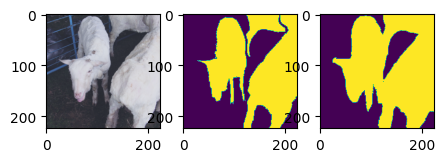

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(5, 15))

axs[0].imshow(m(pixel_values[0]).permute(1, 2, 0).cpu().numpy())
axs[1].imshow(ground_truth_masks[0].cpu().numpy())
axs[2].imshow(predicted_masks[0].cpu().numpy())
mean_iou(ground_truth_masks, predicted_masks, ids)

# Pascal Context

In [41]:
! cp {GOOGLE_DIR}/trainval.tar.gz {LOCAL_DIR}
! cp {GOOGLE_DIR}/VOCtrainval_03-May-2010.tar {LOCAL_DIR}

! tar -xvf {GOOGLE_DIR}/trainval.tar.gz -C {LOCAL_DIR}
! tar -xvf {GOOGLE_DIR}/VOCtrainval_03-May-2010.tar -C {LOCAL_DIR}

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2010/JPEGImages/2010_004750.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004751.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004753.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004756.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004757.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004760.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004763.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004765.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004766.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004768.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004770.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004772.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004773.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004775.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004777.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004778.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004779.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004782.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004783.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004785.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004786.jpg
VOCd

In [104]:
from scipy.io import loadmat

class PascalContextEval(Dataset):
    def __init__(self, val_ids_file, image_dir, annotation_dir, img_size=224):
        """
        Args:
            image_dir (string): Directory with all the images.
            annotation_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = []
        with open(val_ids_file, 'r') as file:
            for line in file:
                id = line.strip() + ".jpg"
                self.images.append(id)

        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.img_size = img_size

        # Load the label mapping
        self.digit_to_object_mapping = {}
        with open('/scratch/t.tovi/datasets/labels.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(':')
                self.digit_to_object_mapping[int(key)] = value.strip()

        # self.selected_labels = [
        #     0, 2, 259, 260, 415, 324, 9, 258, 144, 18, 19, 22,
        #     23, 397, 25, 284, 158, 159, 416, 33, 162, 420, 454, 295, 296,
        #     427, 44, 45, 46, 308, 59, 440, 445, 31, 232, 65, 354, 424,
        #     68, 326, 72, 458, 34, 207, 80, 355, 85, 347, 220, 349, 360,
        #     98, 187, 104, 105, 366, 189, 368, 113, 115]

        self.selected_labels = list(self.digit_to_object_mapping.keys())

    def center_crop(self, image, mask):
        transform = transforms.CenterCrop(self.img_size)
        return transform(image), transform(mask)

    def resize(self, image, mask):
        transform = transforms.CenterCrop(min(image.size))

        cropped_image = transform(image)
        cropped_mask = transform(mask)

        resized_image = transforms.Resize((self.img_size, self.img_size),transforms.InterpolationMode.BILINEAR)(cropped_image)
        resized_mask= transforms.Resize((self.img_size, self.img_size), transforms.InterpolationMode.NEAREST)(cropped_mask)
        return resized_image, resized_mask

    def __len__(self):
        return len(self.images)

    def get(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.mat'))
        annotation = loadmat(annotation_name)['LabelMap']
        annotation = Image.fromarray(annotation)

        ids = np.unique(np.array(annotation))
        ids = [id for id in ids if id in self.selected_labels]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        return image, annotation, labels

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.mat'))
        annotation = loadmat(annotation_name)['LabelMap']
        annotation = Image.fromarray(annotation)

        image, mask = self.resize(image, annotation)
        mask = np.array(mask)

        # Indexed masks
        ids = np.unique(mask)
        ids = [id for id in ids if id in self.selected_labels]
        nonempty_masks = [np.full(mask.shape, id) * (mask==id) for id in ids]
        nonempty_masks = sorted(nonempty_masks, key=lambda x: np.sum(x!=0), reverse=True)

        # Get ids and labels
        ids = [np.unique(mask)[-1] for mask in nonempty_masks]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        # Convert to binary masks
        nonempty_masks = [(mask != 0).astype(float) for mask in nonempty_masks]
        ids = [int(id) for id in ids]
        sample = {'image': image, 'annotation': nonempty_masks, 'labels': labels, 'ids': ids}

        return sample

In [105]:
device = 0

src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "VOCdevkit/VOC2010/JPEGImages/"
annotation_dir = "trainval/"
val_ids = "VOCdevkit/VOC2010/ImageSets/Main/val.txt"

# Create dataset object
data = PascalContextEval(
    dataset_dir+val_ids,
    dataset_dir+image_dir,
    dataset_dir+annotation_dir,
    img_size=224
)

In [106]:
# Get loss query table

labels = data.digit_to_object_mapping
label_indices = list(labels.keys())
label_text = ["a photo of unlabled"] + ["a photo of " + labels[each] for each in label_indices]
label_indices = processor(label_text, padding=True, return_tensors='pt')['input_ids']

with torch.no_grad():
    label_embeddings = lang_model.text_model(label_indices)["pooler_output"]
    eos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.eos_token_id]))["pooler_output"]
    bos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.bos_token_id]))["pooler_output"]

    label_embeddings = lang_model.text_projector(label_embeddings)
    eos_embedding = lang_model.text_projector(eos_embedding)
    bos_embedding = lang_model.text_projector(bos_embedding)

label_embeddings.requires_grad_(False)
eos_embedding.requires_grad_(False)
bos_embedding.requires_grad_(False)

reverse_mapping = {v: k for k, v in data.digit_to_object_mapping.items()}

In [107]:
# Get the collate function
collate_fn = collate_fn_factory(processor)

# Create batch data loader
data_loader = DataLoader(data, batch_size=1, collate_fn=collate_fn, num_workers=2, shuffle=False)

m = nn.Sigmoid()
label_embeddings = label_embeddings.to(0).detach()
label_embeddings = F.normalize(label_embeddings, dim=-1)

In [108]:
with torch.no_grad():
    all_miou = []
    for batch in tqdm.tqdm(data_loader):
        pixel_values = batch['pixel_values'].to(device)
        masks = batch['masks'].to(device)
        ids = batch['ids'].to(device)

        mask_logits, pred_embeddings = model(pixel_values)

        ids = batch['ids'].squeeze(0)
        ids = ids[ids != 0]
        ground_truth_embeddings = label_embeddings[ids]
        predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
        correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

        predicted_masks = (m(mask_logits[0, correspondence])> 0.2).int()
        for i in range(len(ids)):
            predicted_masks[i] = predicted_masks[i] * ids[i]

        ground_truth_masks = masks.squeeze(0)[: len(ids)]
        for i in range(len(ids)):
            ground_truth_masks[i] = ground_truth_masks[i] * ids[i]

        score = mean_iou(ground_truth_masks, predicted_masks, ids)
        all_miou.append(score)

        break

        if len(all_miou) % 100 == 0:
            print(np.mean(all_miou))


  0%|          | 0/5105 [00:00<?, ?it/s]


In [227]:
with torch.no_grad():
    all_miou = []
    for batch in tqdm.tqdm(data_loader):
        pixel_values = batch['pixel_values'].to(device)
        masks = batch['masks'].to(device)
        ids = batch['ids'].to(device)

        mask_logits, pred_embeddings = model(pixel_values)

        ids = batch['ids'].squeeze(0)
        ids = ids[ids != 0]
        ground_truth_embeddings = label_embeddings[ids]
        predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
        correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

        predicted_masks = m(mask_logits[0, correspondence])
        predicted_masks = torch.argmax(predicted_masks, 0)
        final_pmasks = []
        for i in range(len(ids)):
            final_pmasks.append((predicted_masks==i).int())
        predicted_masks = torch.stack(final_pmasks, 0)

        for i in range(len(ids)):
            predicted_masks[i] = predicted_masks[i] * ids[i]

        ground_truth_masks = masks.squeeze(0)[: len(ids)]
        for i in range(len(ids)):
            ground_truth_masks[i] = ground_truth_masks[i] * ids[i]

        score, _ = mean_iou(ground_truth_masks, predicted_masks, ids)
        all_miou.append(score)

        if len(all_miou) % 100 == 0:
            print(np.mean(all_miou))


  0%|          | 0/5105 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  2%|▏         | 101/5105 [00:21<08:31,  9.79it/s]

0.47197637076898347


  4%|▍         | 202/5105 [00:32<07:58, 10.25it/s]

0.4678479371347901


  6%|▌         | 302/5105 [00:43<07:44, 10.33it/s]

0.44941758732775117


  8%|▊         | 401/5105 [00:54<07:45, 10.11it/s]

0.45392910103658013


 10%|▉         | 501/5105 [01:05<12:53,  5.96it/s]

0.449177819346417


 12%|█▏        | 601/5105 [01:17<10:47,  6.95it/s]

0.44766356856482314


 14%|█▎        | 701/5105 [01:31<10:40,  6.88it/s]

0.4386038661727335


 16%|█▌        | 802/5105 [01:42<07:06, 10.10it/s]

0.42999504464382293


 18%|█▊        | 901/5105 [01:55<11:18,  6.19it/s]

0.42931452030064027


 20%|█▉        | 1002/5105 [02:06<06:41, 10.23it/s]

0.4254352958254832


 22%|██▏       | 1100/5105 [02:18<06:35, 10.12it/s]

0.4261782621982772


 24%|██▎       | 1200/5105 [02:29<07:13,  9.01it/s]

0.4268107279895861


 25%|██▌       | 1301/5105 [02:40<09:43,  6.52it/s]

0.42869369954820774


 27%|██▋       | 1401/5105 [02:51<06:24,  9.64it/s]

0.42997306164243826


 29%|██▉       | 1501/5105 [03:03<06:12,  9.68it/s]

0.43218089703775087


 31%|███▏      | 1602/5105 [03:14<05:52,  9.93it/s]

0.43239812836807473


 33%|███▎      | 1701/5105 [03:26<05:58,  9.50it/s]

0.43307529508317244


 35%|███▌      | 1801/5105 [03:37<09:13,  5.96it/s]

0.4323494171573629


 37%|███▋      | 1901/5105 [03:48<05:55,  9.01it/s]

0.43359874648409436


 39%|███▉      | 2001/5105 [03:59<05:28,  9.45it/s]

0.43173191295928914


 41%|████      | 2101/5105 [04:11<04:56, 10.14it/s]

0.43183058707856203


 43%|████▎     | 2201/5105 [04:25<05:09,  9.38it/s]

0.43237056023386383


 45%|████▌     | 2300/5105 [04:36<04:34, 10.21it/s]

0.4318034651313212


 47%|████▋     | 2402/5105 [04:48<05:28,  8.24it/s]

0.43310869254068174


 49%|████▉     | 2501/5105 [04:59<05:57,  7.28it/s]

0.434450133957989


 51%|█████     | 2601/5105 [05:10<04:23,  9.49it/s]

0.4357965698256684


 53%|█████▎    | 2701/5105 [05:21<04:04,  9.83it/s]

0.43723296498732395


 55%|█████▍    | 2801/5105 [05:33<03:58,  9.65it/s]

0.437335721871502


 57%|█████▋    | 2901/5105 [05:45<03:49,  9.62it/s]

0.4386592343807519


 59%|█████▉    | 3001/5105 [05:56<05:07,  6.85it/s]

0.43906351767918206


 61%|██████    | 3102/5105 [06:06<03:24,  9.81it/s]

0.4395954613491533


 63%|██████▎   | 3201/5105 [06:18<03:15,  9.75it/s]

0.439437151656652


 65%|██████▍   | 3302/5105 [06:30<03:04,  9.76it/s]

0.4386301126031845


 67%|██████▋   | 3401/5105 [06:41<02:58,  9.55it/s]

0.43726563665401524


 69%|██████▊   | 3502/5105 [06:54<02:50,  9.40it/s]

0.4380149899926293


 71%|███████   | 3601/5105 [07:05<03:41,  6.78it/s]

0.4385724968523581


 73%|███████▎  | 3702/5105 [07:16<02:22,  9.86it/s]

0.4382986872140964


 74%|███████▍  | 3801/5105 [07:28<02:14,  9.67it/s]

0.439107714782437


 76%|███████▋  | 3901/5105 [07:39<02:06,  9.53it/s]

0.4403771817631152


 78%|███████▊  | 4001/5105 [07:51<01:54,  9.64it/s]

0.4413211869588959


 80%|████████  | 4101/5105 [08:02<01:58,  8.46it/s]

0.44147398749910405


 82%|████████▏ | 4201/5105 [08:13<02:02,  7.36it/s]

0.44168824883622976


 84%|████████▍ | 4301/5105 [08:24<01:26,  9.29it/s]

0.4418668231790254


 86%|████████▌ | 4401/5105 [08:36<01:11,  9.86it/s]

0.4425629698542687


 88%|████████▊ | 4502/5105 [08:48<00:59, 10.06it/s]

0.4428282720239698


 90%|█████████ | 4601/5105 [08:59<00:52,  9.56it/s]

0.4439361245733269


 92%|█████████▏| 4701/5105 [09:10<01:03,  6.38it/s]

0.44440519430922576


 94%|█████████▍| 4801/5105 [09:22<00:37,  8.12it/s]

0.44466075091778956


 96%|█████████▌| 4902/5105 [09:33<00:19, 10.19it/s]

0.4453772182574467


 98%|█████████▊| 5001/5105 [09:45<00:10,  9.69it/s]

0.4453524700888118


100%|█████████▉| 5101/5105 [09:56<00:00,  9.73it/s]

0.4456298354995506


100%|██████████| 5105/5105 [09:56<00:00, 10.73it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 5105/5105 [09:57<00:00,  8.55it/s]


(0.36036678722926546,
 [0.9220424294471741,
  0.7524168491363525,
  0.8481082320213318,
  0.0,
  0.0,
  0.0,
  0.0])

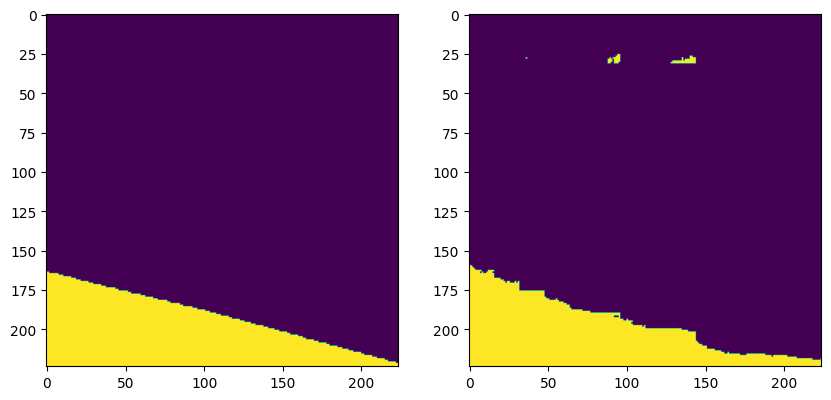

In [147]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

i = 2
axs[0].imshow(ground_truth_masks[i].cpu().numpy())
axs[1].imshow(predicted_masks[i].cpu().numpy())

mean_iou(ground_truth_masks, predicted_masks, ids)

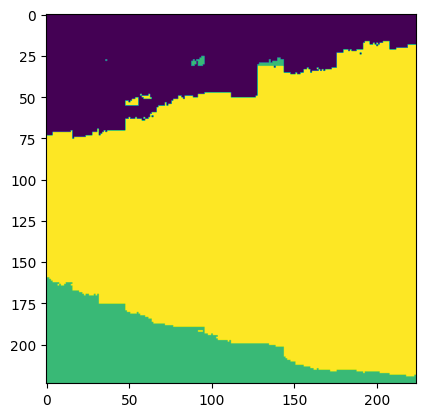

In [148]:
plt.imshow(
    torch.sum(predicted_masks, 0).detach().cpu().numpy()
)

['train', 'building', 'platform', 'sky', 'pole', 'light', 'wire']

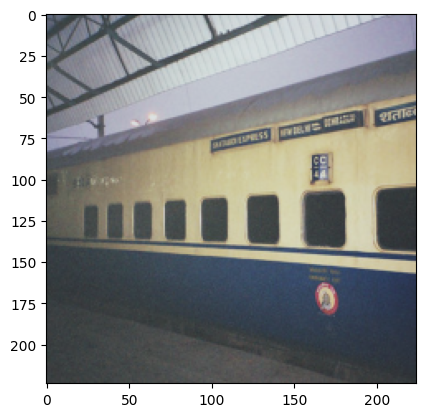

In [150]:
plt.imshow(
    m(pixel_values[0].detach().cpu().permute(1, 2, 0)).numpy()
)
[data.digit_to_object_mapping[each.item()] for each in ids]

In [81]:
labels = ""
for d in data.digit_to_object_mapping.values():
    labels += d + ", "
labels

'accordion, aeroplane, air conditioner, antenna, artillery, ashtray, atrium, baby carriage, bag, ball, balloon, bamboo weaving, barrel, baseball bat, basket, basketball backboard, bathtub, bed, bedclothes, beer, bell, bench, bicycle, binoculars, bird, bird cage, bird feeder, bird nest, blackboard, board, boat, bone, book, bottle, bottle opener, bowl, box, bracelet, brick, bridge, broom, brush, bucket, building, bus, cabinet, cabinet door, cage, cake, calculator, calendar, camel, camera, camera lens, can, candle, candle holder, cap, car, card, cart, case, casette recorder, cash register, cat, cd, cd player, ceiling, cell phone, cello, chain, chair, chessboard, chicken, chopstick, clip, clippers, clock, closet, cloth, clothes tree, coffee, coffee machine, comb, computer, concrete, cone, container, control booth, controller, cooker, copying machine, coral, cork, corkscrew, counter, court, cow, crabstick, crane, crate, cross, crutch, cup, curtain, cushion, cutting board, dais, disc, disc c

In [156]:
test = Image.open('./image.png')
test = np.array(test)
test.shape

(333, 500, 3)

In [218]:
pred = torch.tensor(test[..., 0].astype(int))
gt = torch.tensor(np.array(data.get(1)[1]).astype(int))

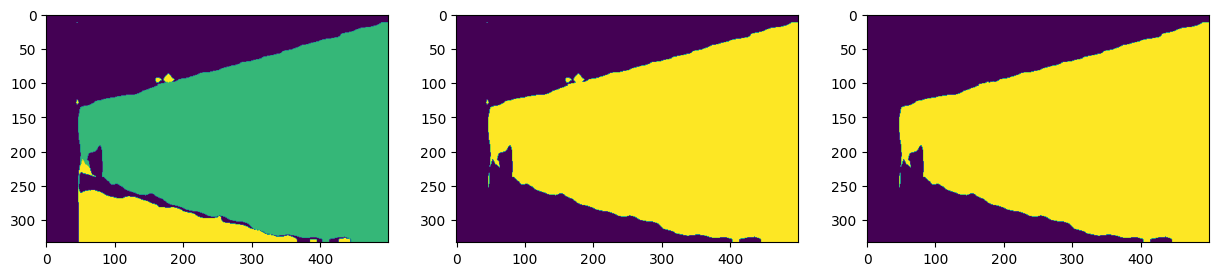

In [225]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(test[..., 0])
axs[1].imshow(test[..., 1])
axs[2].imshow(test[..., 2])

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [170,  84, 255],
        [170,  84, 255],
        [170,  84, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [170,  84, 255],
        [170,  84, 255],
        [170,  84, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [170,  84, 255],
        [170,  84, 255],
        [170,  84, 255]]], dtype=uint8)
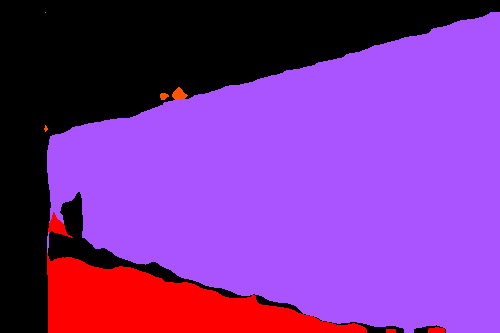

In [226]:
test

In [219]:
np.unique(pred)

array([  0, 170, 255])

In [217]:
np.unique(pred)

array([  0,  84, 170, 255])

IndexError: index 3 is out of bounds for axis 0 with size 3

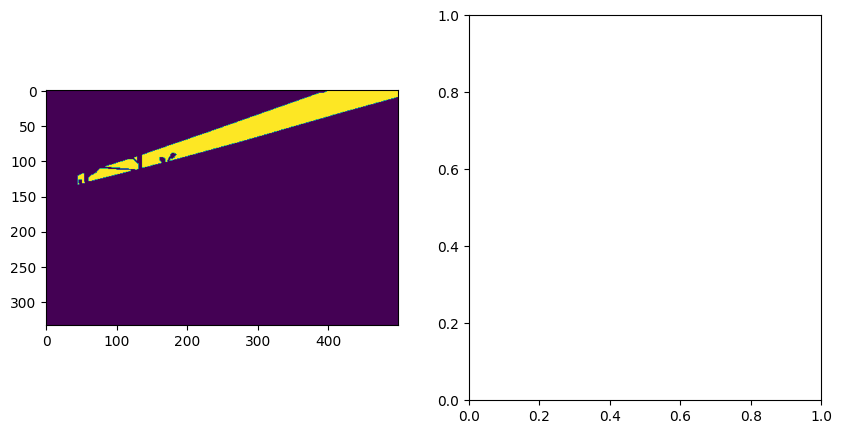

In [220]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow((gt.numpy() == ids[3].item()).astype(int))
axs[1].imshow((pred.numpy() == np.unique(pred)[3]).astype(int))

In [221]:
map = {
    ids[0].item() : np.unique(pred)[1],
    ids[1].item() : np.unique(pred)[0],
    ids[2].item() : np.unique(pred)[2],
}

for k,v in map.items():
    pred[pred == v] = k

In [222]:
mean_iou(gt, pred, ids)

(0.33384494270597187,
 [0.9523311257362366,
  0.6955735087394714,
  0.689009964466095,
  0.0,
  0.0,
  0.0,
  0.0])